In [23]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from tqdm import tqdm_notebook as tqdm
import _pickle as pickle
plt.style.use('ggplot')

In [24]:
bc = pd.read_csv('BTC-USD.csv')
bc.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
358,2019-12-10,7397.134277,7424.022949,7246.043945,7278.119629,7278.119629,18249031194
359,2019-12-11,7277.197754,7324.156250,7195.527344,7217.427246,7217.427246,16350490689
360,2019-12-12,7216.738770,7266.639648,7164.741211,7243.134277,7243.134277,18927080224
361,2019-12-13,7244.662109,7293.560547,7227.122559,7269.684570,7269.684570,17125736940
362,2019-12-17,6932.012207,6951.695801,6928.623535,6929.553223,6929.553223,20084940800


In [25]:
bc['Date'] = pd.to_datetime(bc.Date)
bc.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [26]:
bc.set_index('Date', inplace=True)
bc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-17,3253.123047,3597.917969,3253.123047,3545.864746,3545.864746,5409247918
2018-12-18,3544.761475,3701.349365,3487.169189,3696.059082,3696.059082,5911325472
2018-12-19,3706.824951,3949.322998,3687.229980,3745.950684,3745.950684,6810689118
2018-12-20,3742.195068,4191.228516,3728.974609,4134.441406,4134.441406,8927129279
2018-12-21,4133.703613,4198.429688,3850.946289,3896.543701,3896.543701,7206015706


In [27]:
bc = bc[['Close']].loc['2017-01-01':]
bc.head()

,Close
Date,
2018-12-17,3545.864746
2018-12-18,3696.059082
2018-12-19,3745.950684
2018-12-20,4134.441406
2018-12-21,3896.543701


In [28]:
with open("curr_bitcoin.pickle", 'wb') as fp:
    pickle.dump(bc, fp)

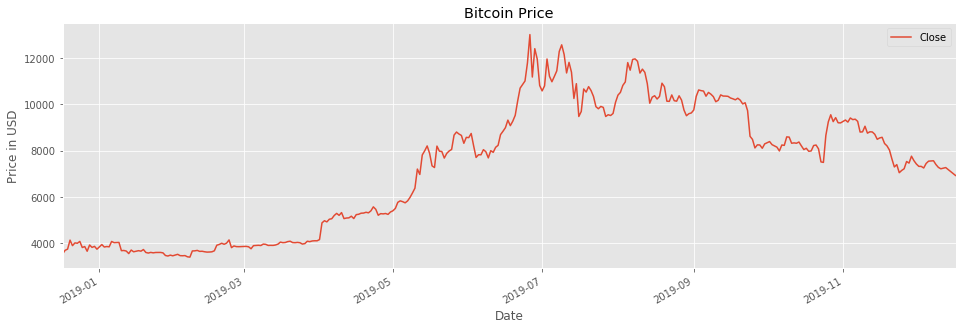

In [29]:
bc.plot(figsize=(16,5))

plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Bitcoin Price')
plt.savefig('btcprice.png')
plt.show()

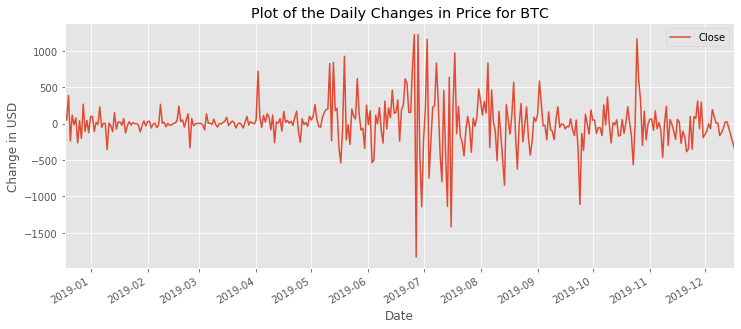

In [30]:
# Differencing the price
bc_diff = bc.diff(1).dropna()

# Plotting the differences daily
bc_diff.plot(figsize=(12,5))
plt.title('Plot of the Daily Changes in Price for BTC')
plt.ylabel('Change in USD')
plt.show()

In [31]:
results = adfuller(bc_diff.Close)
print(f"P-value: {results[1]}")

P-value: 0.0
